### RTP Model Evaluation

This notebook is to use the parameters found in the experiments, retrain, and evaluate against unseen test data.

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

import RTP.TemporalAbstraction as ta
from  RTP.RTP_classifier import RTPclf, preprocess
from RTP.Config import Options as opts

from tools.tools import train_test_split

import warnings
warnings.filterwarnings('ignore')

### Functions to train and evaluate a model

In [2]:
def train(model, rtp_params, pos_train, neg_train, logfile):
    clf = RTPclf(model, rtp_params, logfile)
    MSS_pos, MSS_neg = preprocess(pos_train, neg_train)

    metrics = clf.trainCV(MSS_pos, MSS_neg, 5)
    metrics['model'] = str(model)
    metrics['train/test'] = 'train'
    metrics['max_gap'] = rtp_params['max_gap']
    metrics['min_support_pos'] = rtp_params['min_support_pos']
    metrics['min_support_neg'] = rtp_params['min_support_neg']
    return clf, metrics

In [3]:
def evaluate(clf, pos_test, neg_test):
    MSS_test_pos, MSS_test_neg = preprocess(pos_test, neg_test)

    labels = [1 for _ in range(len(MSS_test_pos))]
    labels.extend([0 for _ in range(len(MSS_test_neg))])

    pred_labels, metrics = clf.evaluate(MSS_test_pos, MSS_test_neg, verbose=False)
    metrics['model'] = str(clf.model)
    metrics['train/test'] = 'test'

    print(classification_report(labels, pred_labels))
    cm = confusion_matrix(labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cbar=False)
    plt.title(str(clf.model))
    plt.show()
    return metrics

#### Load data sets (both train and test)

In [4]:
pos_train_path = os.path.join('./data', 'pos_train.csv')
pos_train = pd.read_csv(pos_train_path)

neg_train_path = os.path.join('./data', 'neg_train.csv')
neg_train = pd.read_csv(neg_train_path)

pos_test_path = os.path.join('./data', 'pos_test.csv')
pos_test = pd.read_csv(pos_test_path)

neg_test_path = os.path.join('./data', 'neg_test.csv')
neg_test = pd.read_csv(neg_test_path)



And load best parameters

In [5]:
params_path = os.path.join('./RTP/results', 'best_parameters.json')
with open(params_path, 'r') as FP:
    best_params = json.load(FP)

Set up logging

In [6]:
logfile = os.path.join('./RTP/logs', 'test_rtp.log')
if os.path.exists(logfile):
    os.remove(logfile)

#### Train and evaluate SVM as found in experiments

Train the SVM model

In [7]:
params = best_params['SVM']
model = SVC(gamma=0.1, C=1.0, kernel=params['kernel'])
rtp_params = {'max_gap': params['max_gap'], 
              'min_support_pos': params['min_support_pos'], 
              'min_support_neg': params['min_support_neg']}
svm_clf, svm_train_metrics = train(model, rtp_params, pos_train, neg_train, logfile)
svm_train_metrics['kernel'] = params['kernel']
print(f'Final Training Accuracy: {svm_train_metrics["accuracy"] * 100: .2f}%')
print(f'Parameters: {params}')
test_results = pd.DataFrame([svm_train_metrics],
                            columns=['model', 'kernel', 'max_gap', 'min_support_pos',
                                     'min_support_neg', 'train/test', 'accuracy', 
                                     'precision', 'recall', 'f1', 'auc'])


100%|██████████| 361/361 [00:10<00:00, 34.32it/s] 


Generating binary matrix, this may take several minutes...
Whew, that was hard!
Beginning training SVM with 5-fold validation...
Fold 1: train_accuracy = 0.8477508650519031 val_accuracy = 0.9444444444444444
Fold 2: train_accuracy = 0.856401384083045 val_accuracy = 0.8819444444444444
Fold 3: train_accuracy = 0.8719723183391004 val_accuracy = 0.8125
Fold 4: train_accuracy = 0.8996539792387543 val_accuracy = 0.6666666666666666
Fold 5: train_accuracy = 0.8858131487889274 val_accuracy = 0.75
Training completed!
Final Training Accuracy:  81.11%
Parameters: {'kernel': 'poly', 'max_gap': 9.0, 'min_support_pos': 0.1, 'min_support_neg': 0.1}


Evaluate the SVM model

100%|██████████| 37/37 [00:01<00:00, 36.17it/s] 


              precision    recall  f1-score   support

           0       1.00      0.68      0.81        37
           1       0.76      1.00      0.86        37

    accuracy                           0.84        74
   macro avg       0.88      0.84      0.83        74
weighted avg       0.88      0.84      0.83        74



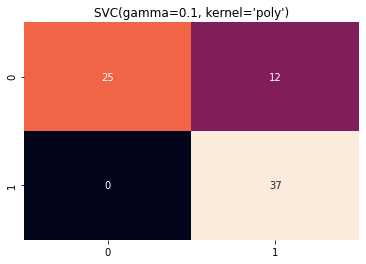

In [8]:
svm_test_metrics = evaluate(svm_clf, pos_test, neg_test)
svm_test_metrics['kernel'] = params['kernel']
svm_test_metrics['max_gap'] = rtp_params['max_gap']
svm_test_metrics['min_support_pos'] = rtp_params['min_support_pos']
svm_test_metrics['min_support_neg'] = rtp_params['min_support_neg']
test_results = test_results.append(svm_test_metrics, ignore_index=True)


#### Logistic Regression

In [9]:
model = LogisticRegression()
rtp_params = best_params['LogisticRegression']
lr_clf, lr_train_metrics = train(model, rtp_params, pos_train, neg_train, logfile)
print(f'Final Training Accuracy: {lr_train_metrics["accuracy"] * 100: .2f}%')
print(f'Parameters: {rtp_params}')
test_results = test_results.append(lr_train_metrics, ignore_index=True)

100%|██████████| 361/361 [00:10<00:00, 34.48it/s] 


Generating binary matrix, this may take several minutes...
Whew, that was hard!
Beginning training SVM with 5-fold validation...
Fold 1: train_accuracy = 0.8477508650519031 val_accuracy = 0.8194444444444444
Fold 2: train_accuracy = 0.8494809688581315 val_accuracy = 0.7777777777777778
Fold 3: train_accuracy = 0.8650519031141869 val_accuracy = 0.8055555555555556
Fold 4: train_accuracy = 0.8598615916955017 val_accuracy = 0.75
Fold 5: train_accuracy = 0.8512110726643599 val_accuracy = 0.7847222222222222
Training completed!
Final Training Accuracy:  78.75%
Parameters: {'max_gap': 10.0, 'min_support_pos': 0.3, 'min_support_neg': 0.3}


100%|██████████| 37/37 [00:00<00:00, 57.04it/s] 


              precision    recall  f1-score   support

           0       0.90      0.73      0.81        37
           1       0.77      0.92      0.84        37

    accuracy                           0.82        74
   macro avg       0.84      0.82      0.82        74
weighted avg       0.84      0.82      0.82        74



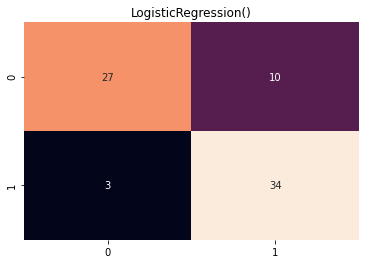

In [10]:
lr_test_metrics = evaluate(lr_clf, pos_test, neg_test)
lr_test_metrics['max_gap'] = rtp_params['max_gap']
lr_test_metrics['min_support_pos'] = rtp_params['min_support_pos']
lr_test_metrics['min_support_neg'] = rtp_params['min_support_neg']
test_results = test_results.append(lr_test_metrics, ignore_index=True)


#### Full results

In [11]:
test_results_path = os.path.join('./RTP/results', 'test_results.csv')
test_results.to_csv(test_results_path, index=False)
test_results

,model,kernel,max_gap,min_support_pos,min_support_neg,train/test,accuracy,precision,recall,f1,auc
0,"SVC(gamma=0.1, kernel='poly')",poly,9.0,0.1,0.1,train,0.811111,0.753950,0.925208,0.830846,0.810793
1,"SVC(gamma=0.1, kernel='poly')",poly,9.0,0.1,0.1,test,0.837838,0.755102,1.000000,0.860465,0.837838
2,LogisticRegression(),NaN,10.0,0.3,0.3,train,0.787500,0.772251,0.817175,0.794078,0.787417
3,LogisticRegression(),NaN,10.0,0.3,0.3,test,0.824324,0.772727,0.918919,0.839506,0.824324
